# Load modules

In [2]:
import numpy as np
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load file with resolved tidal data

In [3]:
NC = netCDF4.Dataset('warner.3d.nc')
time = NC.variables['time'][1:] # exclude initial tidal snapshot (avoid double-couting during tidal averaging)
nmax = len(time)
dx = NC.variables['dx'][:]
dy = NC.variables['dy'][:]

## Location of cross-section

In [4]:
i = 45 ; j = 0

In [5]:
xcl = NC.variables['xc'][i]
xcr = NC.variables['xc'][i+1]
xi = 0.5 * ( xcl + xcr ) # average to U-point interface between center cells
print( 'Analyze cross-section ', xi/1000, ' km upstream of open boundary.' )

Analyze cross-section  22.5  km upstream of open boundary.


## Analyze water depth

Read bathymetry (water depth below z=0):

In [6]:
bathyl = NC.variables['bathymetry'][j,i]
bathyr = NC.variables['bathymetry'][j,i+1]
bathyi = 0.5 * ( bathyl + bathyr ) # average to U-point interface between center cells

Read time-varying sea surface elevation (water height above z=0):

In [7]:
elevl = NC.variables['elev'][:,j,i]
elevr = NC.variables['elev'][:,j,i+1]
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] ) # average in space and time

Calculate time-varying and mean water depth:

In [8]:
Di = bathyi + elevi
Di_mean = Di.mean()

Show in a plot:

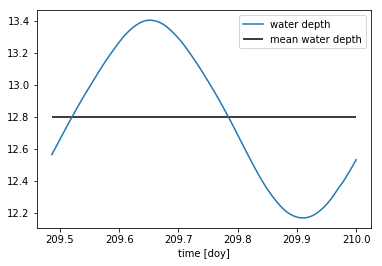

In [9]:
plt.plot( time/86400 , Di , label = 'water depth' )
plt.hlines( Di_mean , time[0]/86400 , time[-1]/86400 , label = 'mean water depth' )
plt.xlabel('time [doy]')
plt.legend()
plt.show()

## Analyze depth-averaged velocity

time-varying depth-averaged velocity:

In [10]:
u2d = NC.variables['u'][1:,j,i]

In [11]:
u2d_mean = u2d.mean()
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-averaged velocity is <u2d> = -0.017510591


## Analyze depth-integrated transport

In [12]:
Di_mean_u2d_mean = Di_mean * u2d_mean
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = ', dy*Di_mean_u2d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u2d> =  -112.02670633792877


Q: Why does this value not reproduce the river input Qr=50 ???  
A: Because we have to calculate `dy*<D*u2d>` !!!

Calculate time-varying and mean depth-integrated transport:

In [13]:
Du2d = Di * u2d
Du2d_mean = Du2d.mean()
print( 'Mean depth-integrated transport is dy*<D*u2d> =', dy*Du2d_mean )

Mean depth-integrated transport is dy*<D*u2d> = -50.34038797020912


Q: Why is there still a deviation between `dy*<D*u2d>` and Qr ???  
A: Slightly non-periodic model state

## Define mean transport velocity

In [14]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> =', u2d_twa )
print( 'Mean depth-averaged velocity was <u2d> =', u2d_mean )

Mean depth-integrated transport velocity is <D*u2d>/<D> = -0.00786857
Mean depth-averaged velocity was <u2d> = -0.017510591


`u2d_twa = <D*u2d>/<D>` is the mean velocity consistent with the volume transport !!!

## 2D guess for Qin and Qout

In [15]:
print( '2D guess for Qin  from tidally-averaged data is  dy*<D*u2d>^+ =',  np.fmax( 0 , Du2d_mean ) * dy ) # only consider positive transports
print( '2D guess for Qout from tidally-averaged data is -dy*<D*u2d>^- =', -np.fmin( Du2d_mean , 0 ) * dy ) # only consider negative transports

2D guess for Qin  from tidally-averaged data is  dy*<D*u2d>^+ = 0.0
2D guess for Qout from tidally-averaged data is -dy*<D*u2d>^- = 50.34038797020912


## Check volume balance

In [16]:
t0 = NC.variables['time'][ 0]
t1 = NC.variables['time'][-1]
bathy = NC.variables['bathymetry'][j,i+1:]
elev0 = NC.variables['elev'][ 0,j,i+1:]
elev1 = NC.variables['elev'][-1,j,i+1:]
D0 = bathy + elev0
D1 = bathy + elev1
V0 = D0.sum() * dx * dy
V1 = D1.sum() * dx * dy
print(' dV/dt =', ( V1 - V0 ) / ( t1 - t0 ) )

 dV/dt = -0.34038975302662167


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance agrees with Qr+Qin-Qout (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!

# Analyze depth-resolved data

## Calculate layer heights and vertical positions

In [37]:
if 'h' in NC.variables.keys():
    hl = NC.variables['h'][:,1:,j,i]
    hr = NC.variables['h'][:,1:,j,i+1]
    hi = 0.25 * ( hl[:-1,:] + hl[1:,:] + hr[:-1,:] + hr[1:,:] ) # average in space and time
elif 'sigma' in NC.variables.keys():
    sigma = NC.variables['sigma'][:]
    hi = np.outer( Di , np.diff(sigma) ) # (time, zc)
kmax = hi.shape[1]

(112,)
(40,)


(112, 40)

In [18]:
zwi = np.insert( hi, 0, -bathyi, axis=1 ).cumsum(axis=1) # interface position
zci = 0.5 * ( zwi[:,:-1] + zwi[:,1:] ) # center position

## Analyze depth-resolved velocity

In [19]:
u3d = NC.variables['uu'][1:,1:,j,i]

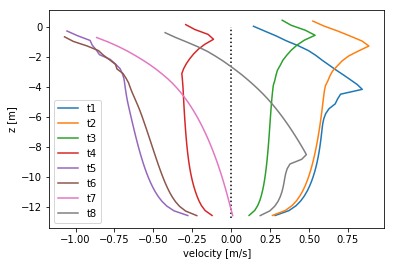

In [20]:
nmax = u3d.shape[0]
nprofs = 8 # should be multiple of 4
for n in range(nmax):
    if not (n+1)%(nmax//nprofs): plt.plot(u3d[n,:],zci[n,:], label='t'+str((n+1)//(nmax//nprofs)))
plt.vlines( 0, -bathyi, 0, linestyles='dotted')
plt.xlabel('velocity [m/s]')
plt.ylabel('z [m]')
plt.legend()    
plt.show()

### Mean depth-resolved velocity

In [21]:
u3d_mean = u3d.mean(axis=0)

### Mean depth-resolved transport velocity

In [22]:
hu3d = hi * u3d
hu3d_mean = hu3d.mean(axis=0)
hi_mean = hi.mean(axis=0)
u3d_twa = hu3d_mean / hi_mean

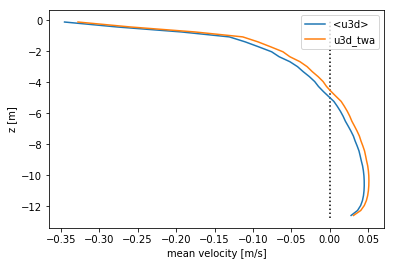

dy*sum(<h>*<u3d>) = -112.02668428409898
dy*sum(<h>*<u3d_twa>) = -50.34039056900846
Mean depth-integrated transport was dy*<D*u2d> = -50.34038797020912


In [23]:
zci_mean = zci.mean(axis=0)
plt.plot(u3d_mean, zci_mean, label='<u3d>')
plt.plot(u3d_twa, zci_mean, label='u3d_twa')
plt.vlines( 0, -bathyi, 0, linestyles='dotted')
plt.xlabel('mean velocity [m/s]')
plt.ylabel('z [m]')
plt.legend()
plt.show()
print( 'dy*sum(<h>*<u3d>) =', dy * np.sum( hi_mean * u3d_mean ) )
print( 'dy*sum(<h>*<u3d_twa>) =', dy * np.sum( hi_mean * u3d_twa ) )
print( 'Mean depth-integrated transport was dy*<D*u2d> =', dy*Du2d_mean )

==> `u3d_twa = <h*u3d>/<h>` is the mean depth-resolved velocity consistent with the volume transport !!!

### 3D guess for Qin and Qout

In [24]:
print( '3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) =',  np.sum( np.fmax( 0 , hu3d_mean ) ) * dy ) # only consider positive transports
print( '3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) =', -np.sum( np.fmin( hu3d_mean , 0 ) ) * dy ) # only consider negative transports

3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) = 154.24356594426868
3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) = 204.58395651327714


# Binning into salinity classes

In [25]:
saltl = NC.variables['salt'][:-1,1:,j,i  ] #include initial, but exclude final state
saltr = NC.variables['salt'][:-1,1:,j,i+1] #include initial, but exclude final state
salt = 0.5 * ( saltl + saltr )

In [26]:
nbins = 10
smin = min( saltl.min() , saltr.min() ) -1e-10
smax = max( saltl.max() , saltr.max() )
Si = np.linspace( smin , smax , nbins+1 )

In [27]:
h_s   = np.zeros((nmax,nbins+1))
hu_s  = np.zeros((nmax,nbins+1))
hus_s = np.zeros((nmax,nbins+1))
for n in range(nmax):
    for k in range(kmax):
        S = salt[n,k]
        upstream_approximation = True
        if upstream_approximation:
            if u3d[n,k] > 0:
                S = saltl[n,k]
            elif u3d[n,k] < 0:
                S = saltr[n,k]
        bin = max( 0 , int( np.ceil( (S-Si[0])/(Si[nbins]-Si[0])*nbins ) ) )
        if bin > nbins: continue
        h_s  [n,bin] = h_s  [n,bin] + hi[n,k]
        hu_s [n,bin] = hu_s [n,bin] + hi[n,k]*u3d[n,k]
        hus_s[n,bin] = hus_s[n,bin] + hi[n,k]*u3d[n,k]*S

In [28]:
h_s_mean   = h_s.mean(axis=0)
hu_s_mean  = hu_s.mean(axis=0)
hus_s_mean = hus_s.mean(axis=0)
u_s_twa = np.zeros_like(h_s_mean)
np.divide( hu_s_mean , h_s_mean , out = u_s_twa , where = (h_s_mean > 0) ) ;

In [29]:
S_s = 0.5 * ( Si[:-1] + Si[1:] )

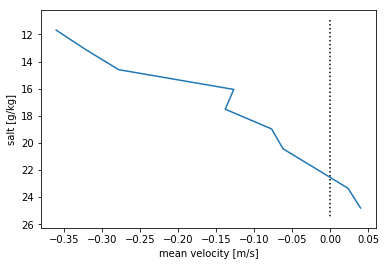

dy*sum(hu_s_mean) = -50.34039056900863


In [30]:
plt.plot(u_s_twa[1:], S_s)
plt.vlines( 0, Si[0], Si[-1], linestyle='dotted')
plt.gca().invert_yaxis()
plt.xlabel('mean velocity [m/s]')
plt.ylabel('salt [g/kg]')
plt.show()
print( 'dy*sum(hu_s_mean) =' , dy*hu_s_mean.sum() )

==> usually more salt bins are used, but then also a longer time series is needed to fill all bins !!!

## Calculate Qin, Qout, Fin, Fout, Sin, Sout

### sign method (MacCready 2011 eq. (3.3) and Lorenz et al. 2019 eq. (5))

In [31]:
Qin  =  np.sum( np.fmax( 0 , hu_s_mean ) ) * dy
Qout = -np.sum( np.fmin( hu_s_mean , 0 ) ) * dy
print( 'isohaline guess for Qin  from tidally-averaged data is  dy*sum( <hu_s>^+ ) =', Qin  )
print( 'isohaline guess for Qout from tidally-averaged data is -dy*sum( <hu_s>^- ) =', Qout )
Fin  =  np.sum( np.fmax( 0 , hus_s_mean ) ) * dy
Fout = -np.sum( np.fmin( hus_s_mean , 0 ) ) * dy
print( 'isohaline guess for Fin  from tidally-averaged data is  dy*sum( <hus_s>^+ ) =', Fin  )
print( 'isohaline guess for Fout from tidally-averaged data is -dy*sum( <hus_s>^- ) =', Fout )
print( 'Sin  = Fin  / Qin  =', Fin /Qin  )
print( 'Sout = Fout / Qout =', Fout/Qout )

isohaline guess for Qin  from tidally-averaged data is  dy*sum( <hu_s>^+ ) = 130.48921954818678
isohaline guess for Qout from tidally-averaged data is -dy*sum( <hu_s>^- ) = 180.82961011719541
isohaline guess for Fin  from tidally-averaged data is  dy*sum( <hus_s>^+ ) = 3217.7528738500278
isohaline guess for Fout from tidally-averaged data is -dy*sum( <hus_s>^- ) = 3023.176091151099
Sin  = Fin  / Qin  = 24.65914720764946
Sout = Fout / Qout = 16.718368685260025


==> wrong convergence behaviour of bulk values from sign method for increasing number of salt bins !!!

### minmax method / dividing salinity method (MacCready 2018 appendix and Lorenz et al. 2019 eq. (7))

In [32]:
Q_le_s = hu_s_mean.cumsum() * dy
Si_idx = Q_le_s.argmin()
Qout = -Q_le_s.min()
Qin  = Q_le_s[-1] + Qout
print( 'isohaline guess for Qin  from tidally-averaged data is ', Qin  )
print( 'isohaline guess for Qout from tidally-averaged data is ', Qout )
F_le_s = hus_s_mean.cumsum() * dy
Fout = -F_le_s[Si_idx]
Fin  = F_le_s[-1] + Fout
print( 'isohaline guess for Fin  from tidally-averaged data is ', Fin  )
print( 'isohaline guess for Fout from tidally-averaged data is ', Fout )
print( 'Sin  = Fin  / Qin  =', Fin /Qin  )
print( 'Sout = Fout / Qout =', Fout/Qout )

isohaline guess for Qin  from tidally-averaged data is  130.48921954818678
isohaline guess for Qout from tidally-averaged data is  180.82961011719541
isohaline guess for Fin  from tidally-averaged data is  3217.752873850028
isohaline guess for Fout from tidally-averaged data is  3023.1760911510996
Sin  = Fin  / Qin  = 24.659147207649465
Sout = Fout / Qout = 16.718368685260028


==> These bulk values are relatively stable for number of salt bins !!!  
==> Fin and Fout are not accurate (compare with salt balance below) !!!  
==> Correct model salt flux cannot be reproduced during postprocessing (see effect of upstream_approximation flag in binning algorithm) !!!  
==> Need of online analysis during model runtime !!!

## Check salt balance

In [33]:
if 'h' in NC.variables.keys():
    h0 = NC.variables['h'][ 0,1:,j,i+1:]
    h1 = NC.variables['h'][-1,1:,j,i+1:]
elif 'sigma' in NC.variables.keys():
    sigma = NC.variables['sigma'][:]
    h0 = np.outer( np.diff(sigma) , D0 ) # (zc, xc)
    h1 = np.outer( np.diff(sigma) , D1 ) # (zc, xc)
salt0 = NC.variables['salt'][ 0,1:,j,i+1:]
salt1 = NC.variables['salt'][-1,1:,j,i+1:]
hS0 = h0 * salt0
hS1 = h1 * salt1
VS0 = hS0.sum() * dx * dy
VS1 = hS1.sum() * dx * dy
print(' d(VS)/dt =', ( VS1 - VS0 ) / ( t1 - t0 ) )

 d(VS)/dt = 29.699386090524495


==> Slightly non-periodic state d(VS)/dt<>0 (could be avoided by avergaing over more tidal cycles) !!!  
==> Salt balance does not agree with approximated Fin-Fout !!!